<a href="https://colab.research.google.com/github/Krish77na/Amazon-review-s-Summarization/blob/main/exp_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [174]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [175]:
data = pd.read_csv('Reviews[1].csv', nrows=100000, error_bad_lines=False)


In [176]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na


In [177]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [178]:
data['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [179]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [180]:
stop_words = set(stopwords.words('english'))
def text_cleaner(text):
    newString = text.lower()
    return newString

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))


In [181]:
data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [182]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:
            newString=newString+i+' '
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [183]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [184]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: i have bought several of the vitality canned dog food products and have found them all to be of good quality. the product looks more like a stew than a processed meat and it smells better. my labrador is finicky and she appreciates this product better than  most.
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled as jumbo salted peanuts...the peanuts were actually small sized unsalted. not sure if this was an error or if the vendor intended to represent the product as "jumbo".
Summary: _START_ not as advertised  _END_


Review: this is a confection that has been around a few centuries.  it is a light, pillowy citrus gelatin with nuts - in this case filberts. and it is cut into tiny squares and then liberally coated with powdered sugar.  and it is a tiny mouthful of heaven.  not too chewy, and very flavorful.  i highly recommend this yummy treat.  if you are familiar with the story of c.s. lewis' "the lion, the witch, and the wardrobe" - this is the 

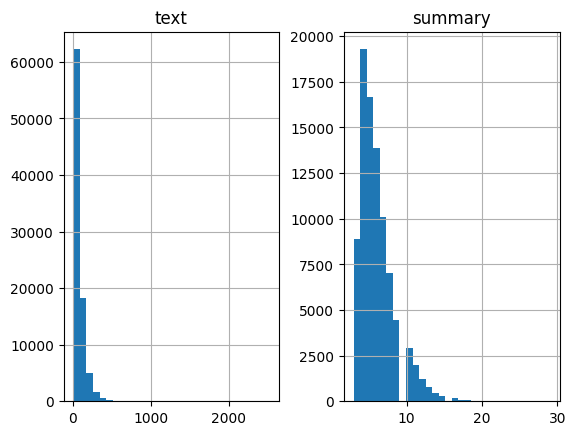

In [185]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [186]:
max_len_text=80
max_len_summary=10

In [187]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [188]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Convert NumPy arrays to lists of strings
x_tr_list = [str(sentence) for sentence in x_tr]
x_val_list = [str(sentence) for sentence in x_val]

# Prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(x_tr_list)

# Convert text sequences into integer sequences
x_tr = x_tokenizer.texts_to_sequences(x_tr_list)
x_val = x_tokenizer.texts_to_sequences(x_val_list)

# Padding zero up to the maximum length

x_tr = pad_sequences(x_tr, maxlen=max_len_text, padding='post')
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) + 1


In [189]:
#preparing a tokenizer for summary on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr)
y_val   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [190]:
from keras import backend as K
K.clear_session()
latent_dim = 500

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs)

#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#LSTM 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])


In [191]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention.
    """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        def energy_step(inputs, states):
            reshaped_states = tf.expand_dims(states[0], axis=1)
            W_a_dot_s = tf.tensordot(reshaped_states, self.W_a, axes=[2, 0])
            U_a_dot_h = tf.tensordot(encoder_out_seq, self.U_a, axes=[2, 1])
            Ws_plus_Uh = tf.keras.activations.tanh(W_a_dot_s + U_a_dot_h)
            v_a = tf.expand_dims(self.V_a, axis=0)
            e_ij = tf.tensordot(Ws_plus_Uh, v_a, axes=[2, 1])
            e_ij = tf.squeeze(e_ij, axis=-1)
            return tf.keras.activations.softmax(e_ij), states

        def context_step(inputs, states):
            c_i = tf.matmul(inputs, encoder_out_seq, transpose_a=True)
            c_i = tf.squeeze(c_i, axis=1)
            return c_i, states

        fake_state_c = tf.zeros_like(encoder_out_seq[:, :, 0])
        fake_state_e = tf.zeros_like(decoder_out_seq[:, 0, :])

        last_out, e_outputs, _ = tf.keras.backend.rnn(energy_step, decoder_out_seq, [fake_state_e],
                                                      go_backwards=False, mask=None)
        last_out, c_outputs, _ = tf.keras.backend.rnn(context_step, e_outputs, [fake_state_c],
                                                      go_backwards=False, mask=None)

        return c_outputs, e_outputs


In [192]:


# Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 80, 500)              2872550   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 80, 500),            2002000   ['embedding[0][0]']           
                              (None, 500),                                                        
                              (None, 500)]                                                    

In [193]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [195]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=20, verbose=1)


In [196]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=15,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/15
156/156 [==============================] - 29s 139ms/step - loss: 3.8237 - val_loss: 2.9955
Epoch 2/15
156/156 [==============================] - 20s 127ms/step - loss: 3.0584 - val_loss: 2.8906
Epoch 3/15
156/156 [==============================] - 20s 128ms/step - loss: 2.9405 - val_loss: 2.8434
Epoch 4/15
156/156 [==============================] - 20s 127ms/step - loss: 2.8381 - val_loss: 2.7313
Epoch 5/15
156/156 [==============================] - 20s 127ms/step - loss: 2.7470 - val_loss: 2.6594
Epoch 6/15
156/156 [==============================] - 20s 127ms/step - loss: 2.6641 - val_loss: 2.6313
Epoch 7/15
156/156 [==============================] - 20s 127ms/step - loss: 2.5930 - val_loss: 2.5552
Epoch 8/15
156/156 [==============================] - 20s 126ms/step - loss: 2.5259 - val_loss: 2.5361
Epoch 9/15
156/156 [==============================] - 20s 127ms/step - loss: 2.4601 - val_loss: 2.4962
Epoch 10/15
156/156 [==============================] - 20s 127ms/step - l

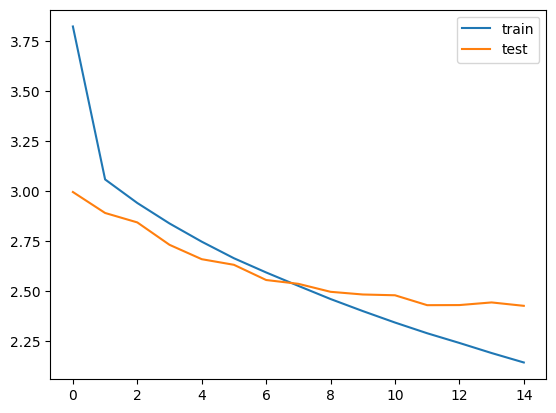

In [197]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [198]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [199]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [200]:
!pip install rouge


In [201]:

import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge




nltk.download('wordnet')

# Function to calculate BLEU, ROUGE, and METEOR scores
def calculate_metrics(reference, candidate):
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()

    # Calculate BLEU score
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.25, 0.25, 0.25, 0.25))

    # Calculate METEOR score - Ensure both the hypothesis and reference are tokenized
    meteor_score_value = meteor_score([reference_tokens], candidate_tokens)

    # Calculate ROUGE score
    rouge = Rouge()
    rouge_score = rouge.get_scores(' '.join(candidate_tokens), ' '.join(reference_tokens), avg=True)

    return bleu_score, meteor_score_value, rouge_score



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [202]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Check if the sampled_token_index is in the reverse_target_word_index
        sampled_token = reverse_target_word_index.get(sampled_token_index, 'UNK')

        if sampled_token != 'end':
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
            if len(decoded_sentence.split()) >= (max_len_summary-1):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence.strip()


In [203]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [204]:
# Set N to the number of samples you want to evaluate
N = min(100, len(x_val))

bleu_scores, meteor_scores, rouge_scores = [], [], []

for i in range(N):
    try:
        reference = seq2summary(y_val[i])
        candidate = decode_sequence(x_val[i].reshape(1, max_len_text))

        # Skip if either the reference or candidate summaries are empty
        if len(reference) == 0 or len(candidate) == 0:
            print(f"Skipping empty summary at index {i}.")
            continue

        bleu, meteor, rouge = calculate_metrics(reference, candidate)

        bleu_scores.append(bleu)
        meteor_scores.append(meteor)
        rouge_scores.append(rouge)

    except Exception as e:
        print(f"Error at index {i}: {e}")




# Calculate average scores
avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
avg_meteor = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0

# Correctly calculate the average ROUGE scores
if rouge_scores:
    avg_rouge = {}
    for key in rouge_scores[0].keys():  # Iterate over keys: 'rouge-1', 'rouge-2', 'rouge-l'
        avg_rouge[key] = {
            'f': sum(rouge_score[key]['f'] for rouge_score in rouge_scores) / len(rouge_scores),
            'p': sum(rouge_score[key]['p'] for rouge_score in rouge_scores) / len(rouge_scores),
            'r': sum(rouge_score[key]['r'] for rouge_score in rouge_scores) / len(rouge_scores)
        }
else:
    avg_rouge = {'rouge-1': {'f': 0, 'p': 0, 'r': 0}, 'rouge-2': {'f': 0, 'p': 0, 'r': 0}, 'rouge-l': {'f': 0, 'p': 0, 'r': 0}}

print(f"Average BLEU Score: {avg_bleu}")
print(f"Average METEOR Score: {avg_meteor}")
print(f"Average ROUGE Scores: {avg_rouge}")


1/1 [==============================] - 0s 23ms/step
Skipping empty summary at index 65.
1/1 [==============================] - 0s 23ms/step
Average BLEU Score: 3.241063450174216e-232
Average METEOR Score: 0.045744036484777234
Average ROUGE Scores: {'rouge-1': {'f': 0.08754354374215467, 'p': 0.0929292929292929, 'r': 0.09890171556838222}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.08610054229915325, 'p': 0.09124579124579123, 'r': 0.09763908930575595}}


In [205]:
for i in range(len(x_val)):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: i ordered the salmon on thursday january 11th and we received it on january 19th the salmon was delicious the wooden box has a nice design and can be used to store items in the future 
Original summary: alaska smokehouse smoked salmon 
1/1 [==============================] - 0s 23ms/step
Predicted summary: delicious UNK UNK UNK UNK UNK UNK UNK UNK


Review: in the fridge at work and offer it to people without looking like you're pushing calories along with caffeine br br for a long time i'd stock highly sweetened coffee beverages in the fridge at work then i noticed that people stopped consuming them and it happened around the same time that i lost interest in that level of sweetness i recommend this drink for those that prefer a lower level of sugar and for old school arabica coffee types 
Original summary: it was perfect little sweet without being too sweet 
1/1 [==============================] - 0s 23ms/step
Predicted summary: great tasting tea UNK UNK UNK UNK UNK UNK


Revie

KeyboardInterrupt: ignored